In [ ]:
import torch
import torch.nn as nn
from tqdm.notebook import tqdm_notebook
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

print(torch.cuda.is_available())


False


In [ ]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5,self).__init__()

        self.c1 = nn.Conv2d(in_channels=1,out_channels=6,kernel_size=5,stride=1,padding=2)
        self.c2 = nn.Conv2d(in_channels=6,out_channels=16,kernel_size=5,stride=1,padding=0)
        self.c3 = nn.Conv2d(in_channels=16,out_channels=120,kernel_size=5,stride=1,padding=0)
        self.avg_pool = nn.AvgPool2d(kernel_size=2,stride=2)
        self.tanh = nn.Tanh()  # Tanh activation function
        self.fc1 = nn.Linear(in_features=120,out_features=84)
        self.fc2 = nn.Linear(in_features=84,out_features=10)

    def forward(self, img):
        x = self.tanh(self.c1(img))
        x = self.tanh(self.avg_pool(x))
        x = self.tanh(self.c2(x))
        x = self.tanh(self.avg_pool(x))
        x = self.tanh(self.c3(x))
        x = torch.flatten(x,1)
        x = self.tanh(self.fc1(x))
        x = self.fc2(x)
        return x


In [ ]:
def Dataset(batch_size):
    transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0,), (1,))
                ])

    trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                            download=True, transform=transform)

    # seperate dataset into train and validation set
    trainset, valset = torch.utils.data.random_split(trainset, [57500, 2500])

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            shuffle=True)

    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                            shuffle=True)

    testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                        download=True, transform=transform)

    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                            shuffle=False)

    return trainloader, valloader, testloader

class Model:
    def __init__(self, model, learning_rate, device):
        self.model = model
        self.lr = learning_rate
        self.loss = nn.CrossEntropyLoss()
        self.opt = torch.optim.Adam(self.model.parameters(), lr = self.lr)
        self.train_loss = []
        self.val_loss = []
        self.train_acc = []
        self.val_acc = []
        self.device = device

    def batch_accuracy(self, output, target):
        # output shape: [batch, 10]
        output = nn.functional.softmax(output, dim=1)
        output = output.argmax(1)
        acc = torch.sum(output==target) / output.shape[0]
        return acc.cpu()*100

    def train_step(self, dataset):
        self.model.train()
        batch_loss = []
        batch_acc = []
        for batch in dataset:
            inputs = batch[0].to(self.device)
            targets = batch[1].to(self.device)
            self.opt.zero_grad()

            outputs = self.model(inputs)

            loss = self.loss(outputs, targets)
            loss.backward()
            self.opt.step()
            batch_loss.append(loss.item())
            batch_acc.append(self.batch_accuracy(outputs,targets))

        self.train_loss.append(np.mean(batch_loss))
        self.train_acc.append(np.mean(batch_acc))

    def validation_step(self, dataset):
        self.model.eval()
        batch_loss = []
        batch_acc = []
        with torch.no_grad():
            for batch in dataset:
                inputs = batch[0].to(self.device)
                targets = batch[1].to(self.device)

                outputs = self.model(inputs)

                loss = self.loss(outputs, targets)
                batch_loss.append(loss.item())
                batch_acc.append(self.batch_accuracy(outputs,targets))

        self.val_loss.append(np.mean(batch_loss))
        self.val_acc.append(np.mean(batch_acc))

    def test_step(self, dataset):
        self.model.eval()
        batch_acc = []
        with torch.no_grad():
            for batch in dataset:
                inputs = batch[0].to(self.device)
                targets = batch[1].to(self.device)

                outputs = self.model(inputs)
                batch_acc.append(self.batch_accuracy(outputs,targets))

        print("Accuracy : ", np.mean(batch_acc), "%")


epochs = 20
device = "cuda" if torch.cuda.is_available() else "cpu"
learning_rate = 1e-4
batch = 32
lenet5 = LeNet5().to(device)
train_loader, val_loader, test_loader = Dataset(batch)
model = Model(lenet5, learning_rate, device)
for epoch in tqdm_notebook(range(epochs), desc='Epoch'):
    model.train_step(train_loader)
    model.validation_step(val_loader)
model.test_step(test_loader)

100%|██████████| 26421880/26421880 [00:01<00:00, 14863454.56it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 269293.77it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5040988.07it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 12731295.40it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Accuracy :  87.430115 %


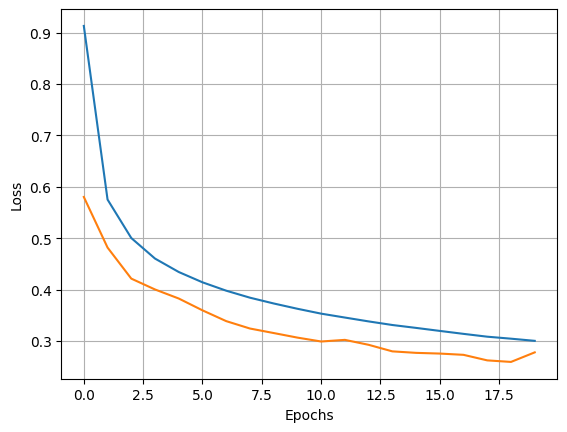

In [ ]:
plt.figure(dpi=100)
plt.grid()
plt.plot(model.train_loss)
plt.plot(model.val_loss)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig("Accuracy.png")

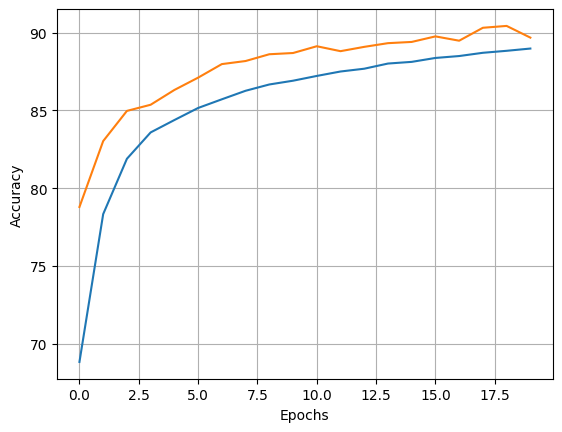

In [ ]:
plt.figure(dpi=100)
plt.grid()
plt.plot(model.train_acc)
plt.plot(model.val_acc)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.savefig("Accuracy.png")